# SAID 
### Back-end demo

## Load the constituent data
In the developed model, the constituent data is suspended-sediment concentration (SSC).
This cell loads SSC observations from a tab-delimited text file, drops the sample method code, and displays the Pandas DataFrame containing the SSC observations.

In [1]:
%matplotlib inline
import os

from linearmodel.datamanager import DataManager

data_directory = r'.\SpoonRiverAcoustics'

# load constituent data (SSC)
ssc_filename = r'spoonSSC.txt'
scc_file_path = os.path.join(data_directory, ssc_filename)
ssc_data = DataManager.read_tab_delimited_data(scc_file_path)

# drop the sample method code
ssc_data = ssc_data.drop_variables(['SampleMethod'])

# show constituent dataset
ssc_data.get_data()

,SSC
DateTime,
2013-02-07 13:00:00,299
2013-02-10 12:00:00,281
2013-02-13 10:30:00,756
2013-02-16 10:15:00,101
2013-02-19 12:00:00,85
2013-02-23 13:00:00,63
2013-02-27 13:00:00,49
2013-03-05 13:00:00,59
2013-03-08 16:00:00,50


## Load the surrogate data
The surrogate variable will ultimately be mean sediment corrected backscatter (MeanSCB). MeanSCB is calculated from raw acoustic backscatter data. The following cell loads the raw backscatter from two sets of Argonaut files and displays the raw data.

In [2]:
from advmdata.sontek import ArgonautADVMData

# load Argonaut data
acoustic_filenames = ['SPOON001', 'SPOON002']
advm_data = ArgonautADVMData.read_argonaut_data(data_directory, acoustic_filenames[0])
for index in range(1, len(acoustic_filenames)):
    tmp_advm_data = ArgonautADVMData.read_argonaut_data(data_directory, acoustic_filenames[index])
    advm_data = advm_data.add_data(tmp_advm_data, keep_curr_obs=True)

# get the acoustic backscatter data from the advm_data
from said.acoustic import ArgonautRawBackscatterData
abs_data = ArgonautRawBackscatterData.from_advm_data(advm_data)

# show the contents of the raw data
abs_data.get_data()

C:\Users\domanski\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Cell07Amp2,Cell09Amp2,Temp,Cell09SNR1,Cell04SNR2,Cell03SNR1,Cell09SNR2,Cell10Amp1,Cell06SNR2,Cell04Amp2,...,Cell05Amp1,Cell10Amp2,Cell10SNR2,Cell02SNR1,Cell05Amp2,Cell03SNR2,Cell03Amp2,Cell01SNR1,Cell06Amp2,Cell05SNR1
2013-01-31 12:41:46,62.0,38.0,0.00,-0.4,35.7,-0.4,2.2,27.0,20.6,116.0,...,27.0,34.0,0.4,-0.4,99.0,45.2,138.0,-0.4,81.0,-0.4
2013-01-31 12:56:46,62.0,39.0,-0.10,-0.9,36.1,-0.9,2.6,27.0,20.2,117.0,...,27.0,34.0,0.4,-0.9,99.0,45.2,138.0,-0.9,80.0,-0.9
2013-01-31 13:11:46,61.0,38.0,-0.17,-0.4,35.7,-0.4,2.2,27.0,19.8,116.0,...,27.0,34.0,0.4,-0.4,98.0,45.2,138.0,-0.4,79.0,-0.4
2013-01-31 13:26:46,62.0,38.0,-0.19,-0.4,35.7,-0.4,2.2,27.0,19.8,116.0,...,27.0,33.0,0.0,-0.4,98.0,45.2,138.0,0.0,79.0,-0.4
2013-01-31 13:41:46,63.0,38.0,-0.20,-0.4,36.5,-0.4,2.6,27.0,20.6,117.0,...,27.0,33.0,0.4,-0.4,99.0,46.0,139.0,0.0,80.0,-0.4
2013-01-31 13:56:46,62.0,37.0,-0.21,-0.4,35.7,-0.4,1.7,27.0,19.4,116.0,...,27.0,33.0,0.0,-0.4,99.0,45.6,139.0,-0.4,78.0,-0.4
2013-01-31 14:11:46,60.0,37.0,-0.21,-0.4,36.5,-0.4,2.2,27.0,19.8,117.0,...,27.0,33.0,0.4,-0.4,99.0,46.0,139.0,-0.4,78.0,-0.4
2013-01-31 14:26:46,59.0,37.0,-0.21,-0.4,36.1,-0.4,2.2,27.0,19.8,116.0,...,27.0,33.0,0.4,-0.4,98.0,45.6,138.0,-0.4,78.0,-0.4
2013-01-31 14:41:46,61.0,37.0,-0.22,-0.4,36.5,-0.4,2.2,27.0,19.8,117.0,...,27.0,33.0,0.4,-0.4,97.0,46.4,140.0,0.0,78.0,-0.4
2013-01-31 14:56:46,62.0,38.0,-0.22,-0.4,36.5,-0.4,2.2,27.0,19.8,118.0,...,27.0,33.0,0.0,-0.4,100.0,46.9,142.0,-0.4,79.0,-0.4


## View the ADVM configuration parameters
In addition to backscatter data, the ArgonautADVMData.read_argonaut_data() method also loads configuration parameters from the Argonaut data set. The next cell shows the configuration parameters that have been loaded from the data set.

In [3]:
# show configuration parameters
configuration_parameters = abs_data.get_configuration_parameters()
configuration_parameters

{'Frequency': 1500.0, 'Effective Transducer Diameter': 0.03, 'Beam Orientation': 'Vertical', 'Slant Angle': 25.0, 'Blanking Distance': 1.0, 'Cell Size': 1.75, 'Number of Cells': 10, 'Number of Beams': 2, 'Instrument': 'SW'}

## Initialize ADVM backscatter data processing parameters
In order to process the backscatter data, the processing class needs user defined processing parameters. The next cell creates and displays default processing parameters.

In [4]:
# create processing parameters and show default parameter values
from said.acoustic import ADVMProcParam
processing_parameters = ADVMProcParam(configuration_parameters['Number of Cells'])
processing_parameters

{'Beam': 1, 'Backscatter Values': 'SNR', 'Intensity Scale Factor': 0.43, 'Minimum Cell Mid-Point Distance': -inf, 'Maximum Cell Mid-Point Distance': inf, 'Minimum Number of Cells': 2, 'Minimum Vbeam': -inf, 'Near Field Correction': True, 'WCB Profile Adjustment': True}

## Create an instance of the backscatter processing class
The ADVMBackscatterDataProcessor class handles the processing of backscatter data for calculating the acoustic parameters MeanSCB and sediment attenuation coefficient (SAC). The following cell initializes a processor instance using the default processing parameters and displays the results.

In [5]:
# create processor and show results using default processing parameters
from said.acoustic import ADVMBackscatterDataProcessor
abs_processor = ADVMBackscatterDataProcessor(abs_data, processing_parameters)
abs_processor.get_acoustic_parameters().get_data()

,MeanSCB,SAC
2013-01-31 12:41:46,10.545952,NaN
2013-01-31 12:56:46,10.067695,NaN
2013-01-31 13:11:46,10.582986,NaN
2013-01-31 13:26:46,10.987365,NaN
2013-01-31 13:41:46,10.989557,NaN
2013-01-31 13:56:46,10.591750,NaN
2013-01-31 14:11:46,10.591750,NaN
2013-01-31 14:26:46,10.591750,NaN
2013-01-31 14:41:46,10.993944,NaN
2013-01-31 14:56:46,10.593944,NaN


## Create a rating model
In the next cell, a rating model is initialized with the following information.

* Constituent variable: SSC
* Surrogate varibale: MeanSCB
* Match method: Mean, centered around constituent observation time
* Mean time window width: 30 minutes

A scatter plot, a model fit line and confidence intervals, is also shown.

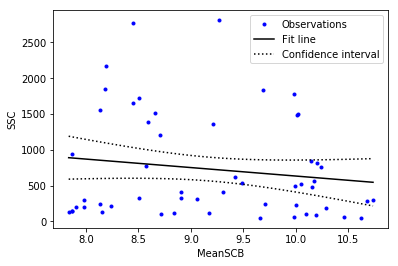

In [6]:
# create a surrogate model using SSC as the constituent and MeanSCB as the surrogate
from said.acoustic import BackscatterRatingModel
rating_model = BackscatterRatingModel(ssc_data, abs_processor, 
                                      constituent_variable='SSC', 
                                      surrogate_variables=['MeanSCB'], 
                                      match_method='mean', 
                                      match_time=30)
rating_model.plot()

## View backscatter profile plots

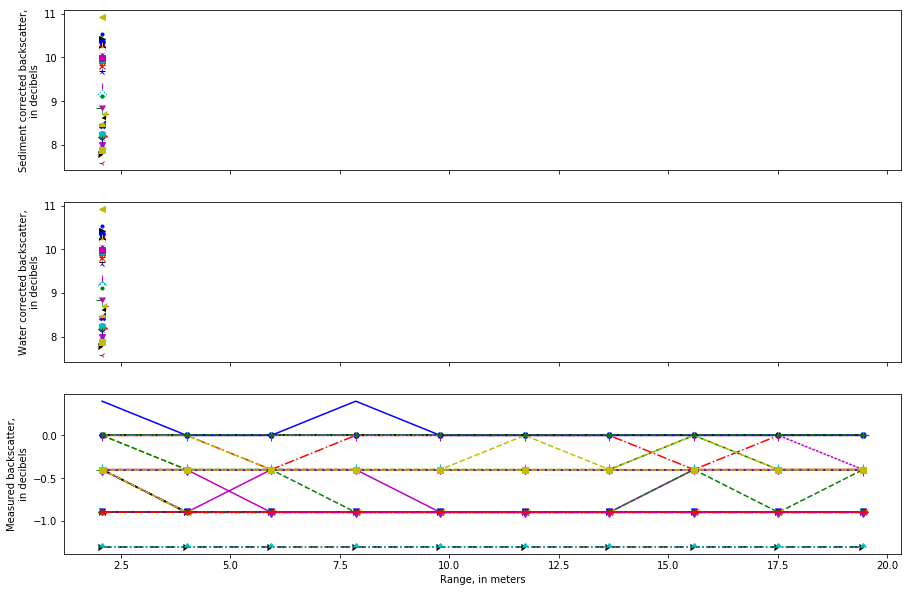

In [7]:
fig = rating_model.plot_backscatter_profiles()
fig.set_size_inches(15, 10)

## Change processing parameters
As shown, the default processing parameters do not produce satisfactory results. The created linear model is unsatisfactory, and the backscatter profiles indicate a problem with the data. 

The next cell changes the processing parameters, recalculates the acoustic parameters, and shows the recalculated values.

In [8]:
# adjust processing parameters and recalculate acoustic parameters
processing_parameters.update({'Backscatter Values': 'Amp',
                              'Beam': 2,
                              'WCB Profile Adjustment': True,
                              'Near Field Correction': True})
abs_processor.calculate_acoustic_parameters(processing_parameters)
abs_processor.get_acoustic_parameters().get_data()

,MeanSCB,SAC
2013-01-31 12:41:46,96.940662,0.651559
2013-01-31 12:56:46,97.003201,0.650287
2013-01-31 13:11:46,97.132649,0.670455
2013-01-31 13:26:46,96.508493,0.633608
2013-01-31 13:41:46,96.752015,0.625126
2013-01-31 13:56:46,97.628471,0.684246
2013-01-31 14:11:46,97.506710,0.688223
2013-01-31 14:26:46,97.884057,0.720036
2013-01-31 14:41:46,98.191202,0.719506
2013-01-31 14:56:46,97.311457,0.647926


## Recreate a rating model

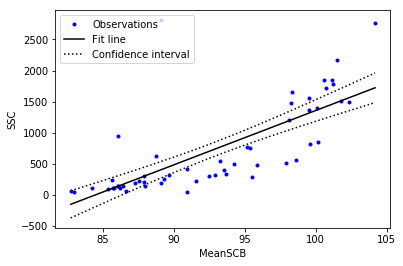

In [9]:
rating_model = BackscatterRatingModel(ssc_data, abs_processor, 
                                      constituent_variable='SSC', 
                                      surrogate_variables=['MeanSCB'], 
                                      match_method='mean', 
                                      match_time=30)
rating_model.plot()

## Transform the constituent variable
The plot above shows a non-linear trend. This can be corrected by log-transforming the constituent variable and bringing it in line with the physically-based and suggested form of the single-frequency sediment acoustic linear model, shown below.

$$\log_{10}{SSC}=\beta_{0}+\beta_{1}\overline{SCB}+\epsilon$$

The following cell transforms the constituent variable and shows the plot of the linear model.

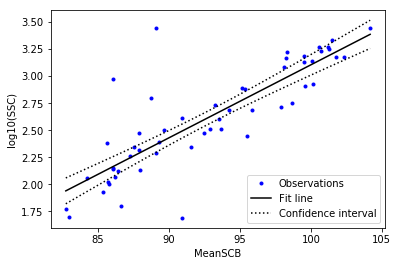

In [10]:
# log10 transform SSC
rating_model.set_constituent_transform('log10')
rating_model.plot()

## Remove outliers
The next cell removes observations that have been determined to be outliers and shows a scatter plot of the linear regression model.

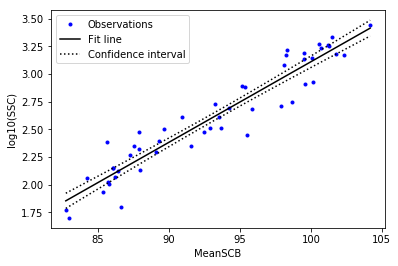

In [11]:
# remove outliers
model_index = rating_model.get_model_dataset().index
rating_model.exclude_observations(model_index[[6, 19, 37, 52]])
rating_model.plot()

## Plot backscatter profiles

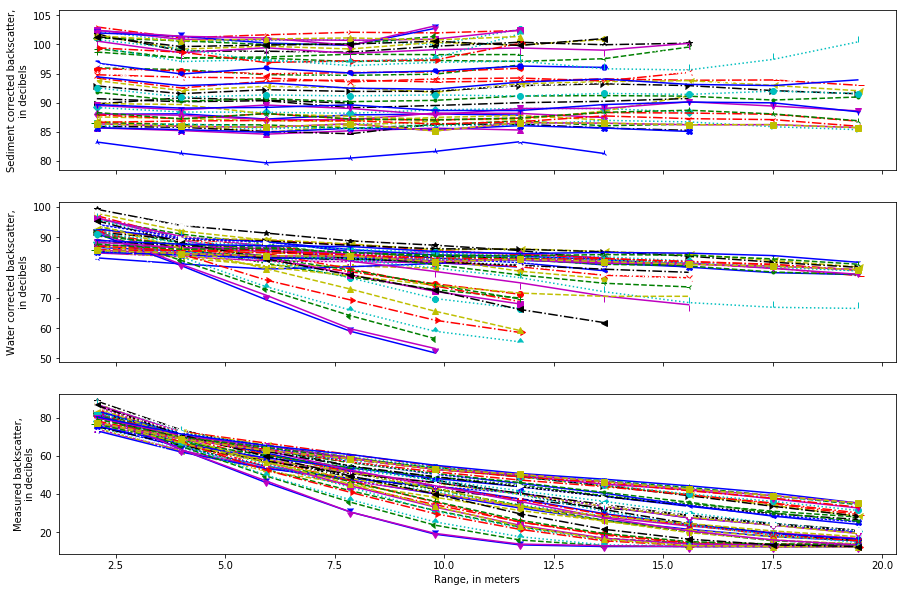

In [12]:
fig = rating_model.plot_backscatter_profiles()
fig.set_size_inches(15, 10)

## Show diagnostic plots
So far, the model is looking pretty good. The next cell creates a single figure with multiple sets of axes and plots some standard diagnostic plots to assess the quality of the regression. The Plots, from left to right and top to bottom are

* Model scatter plot (transformed constituent variable)
* Variable scatter plot (non-transformed constituent variable)
* Model predicted versus observed plot (transformed constituent variable)
* Variable predicted versus observed plot (non-transformed constituent variable)
* Residual versus fitted plot
* Residual probability plot
* Standardized serial correlation coefficient plot
* Residuals plotted against time

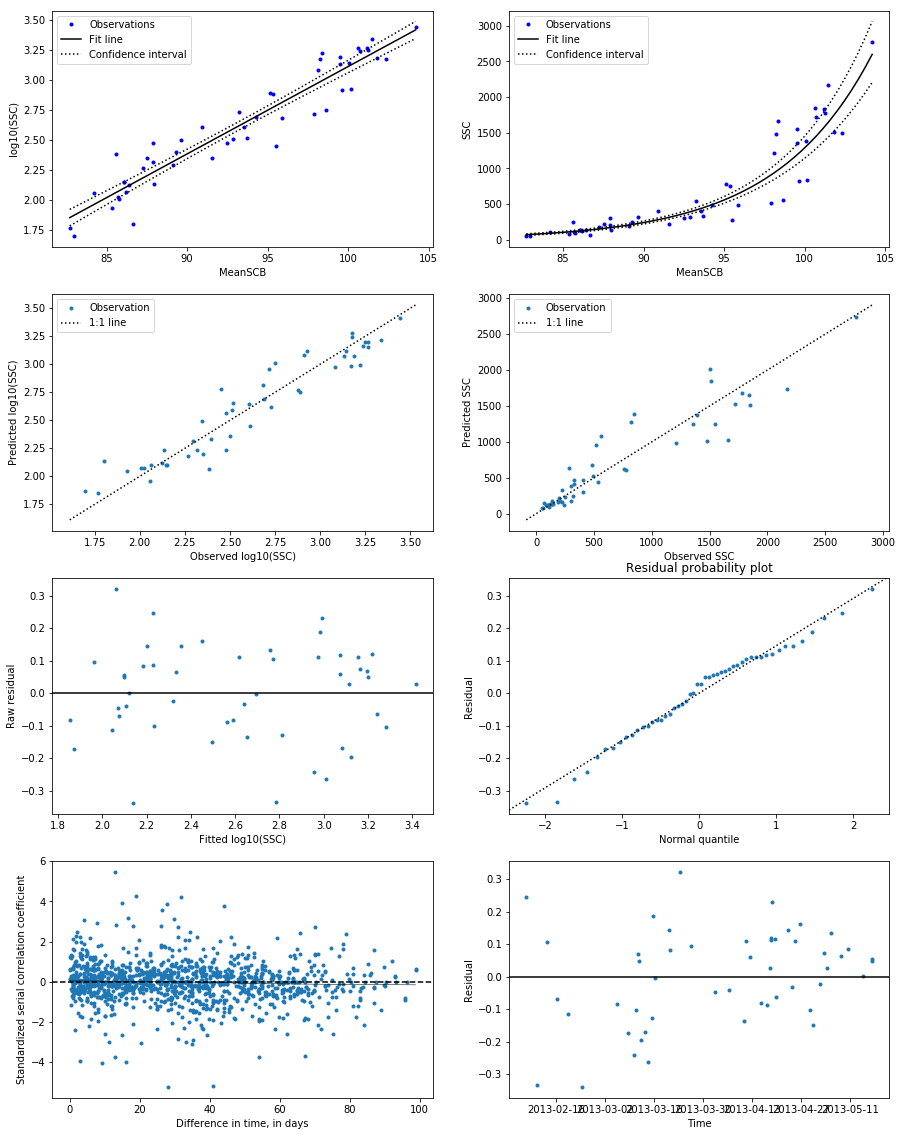

In [13]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
rating_model.plot(ax=ax1)
rating_model.plot('variable_scatter', ax=ax2)
rating_model.plot('model_pred_vs_obs', ax=ax3)
rating_model.plot('pred_vs_obs', ax=ax4)
rating_model.plot('resid_vs_fitted', ax=ax5)
rating_model.plot('resid_probability', ax=ax6)
rating_model.plot('serial_correlation', ax=ax7)
rating_model.plot('resid_vs_time', ax=ax8)
fig.set_size_inches(15, 20)

## Show a quantile plot
The next cell shows a quantile plot of the surrogate observations from the entire time series that was loaded with model observation quantiles indicated.

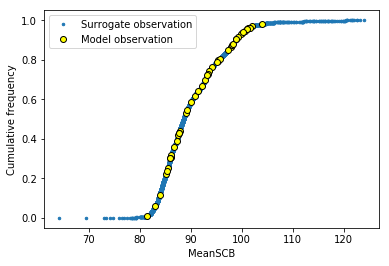

In [14]:
rating_model.plot('quantile')

## Generate model archive report
In the next cell, a report containing standard ordinary least square regression statistics is generated and displayed. The report itself can be saved to a CSV file.

In [15]:
rating_model.get_model_report()

<class 'statsmodels.iolib.summary.Summary'>
"""
======================================
       Linear regression model:       
--------------------------------------
log10(SSC) = -4.1622 + 0.072727MeanSCB
==========================================================================
                 coef    std err          t      P>|t|  [90.0% Conf. Int.]
--------------------------------------------------------------------------
Intercept     -4.1622      0.314    -13.263   1.14e-17    -4.689    -3.636
MeanSCB        0.0727      0.003     21.638   2.10e-26     0.067     0.078
                                        OLSRegression Results                                        
=====================================================================================================
Number of observations                         50   R-squared                                 0.90701
Error degrees of freedom                       48   Adjusted R-squared                        0.90508
Root mean squared error                   0.14739   F-statistic vs. constant model             468.21
Residual PPCC                             0.99077   p-value                                2.0955e-26
Linear correlation coefficient            0.95237   RMSE(%)                                    34.939
===============================================
             High leverage:               0.12 
Extreme outlier (Standardized residual):   3   
       High influence (Cook's D)         2.1923
        High influence (DFFITS)           0.4  


               Variance-covariance matrix              
=======================================================
                Intercept               MeanSCB        
-------------------------------------------------------
Intercept  0.09848449062360488   -0.0010524379256332227
MeanSCB   -0.0010524379256332227 1.1296537671508004e-05
===========================================
Response variable summary                  
-------------------------------------------
                          log10(SSC)  SSC  
         Minimum            1.699      50  
       1st Quartile         2.2648    184  
          Median            2.5622    367  
           Mean             2.6134   700.04
       3rd Quartile         3.1335    1360 
         Maximum            3.4425    2770 
====================================
Explanatory variable summary        
------------------------------------
                             MeanSCB
          Minimum             82.716
        1st Quartile          87.242
           Median             93.402
            Mean              93.165
        3rd Quartile          99.496
          Maximum             104.18
===================================
         Data file location        
-----------------------------------
 .\SpoonRiverAcoustics\spoonSSC.txt
.\SpoonRiverAcoustics\SPOON001(Arg)
.\SpoonRiverAcoustics\SPOON002(Arg)
=============================================================================================================================================================================================================================================================================
      DateTime      SSC       MeanSCB       Obs. number     log10(SSC)     Missing Excluded Fitted log10(SSC)       Raw Residual        Estimated SSC    Normal quantile of residual Standardized Residual       Leverage          Cook's Distance             DFFITS        
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2013-02-07 13:00:00 299  87.90092835278858       1      2.4756711883244296  False   False   2.2305879999945066  0.24508318832992293   179.34871349119723      1.8474868176556123       1.6921715529392891  0.03440741524348476   0.05101723424323049    0.32595539655217176  
2013-02-10 12:00:00 281

## Show a predicted time series
The cell below shows a time series of the predicted constituent using the loaded surrogate time series. The location of included model observations and excluded model observations is indicated. Missing observations would also be indicated if the model data set contained them. Also plotted is the 90% prediction interval.

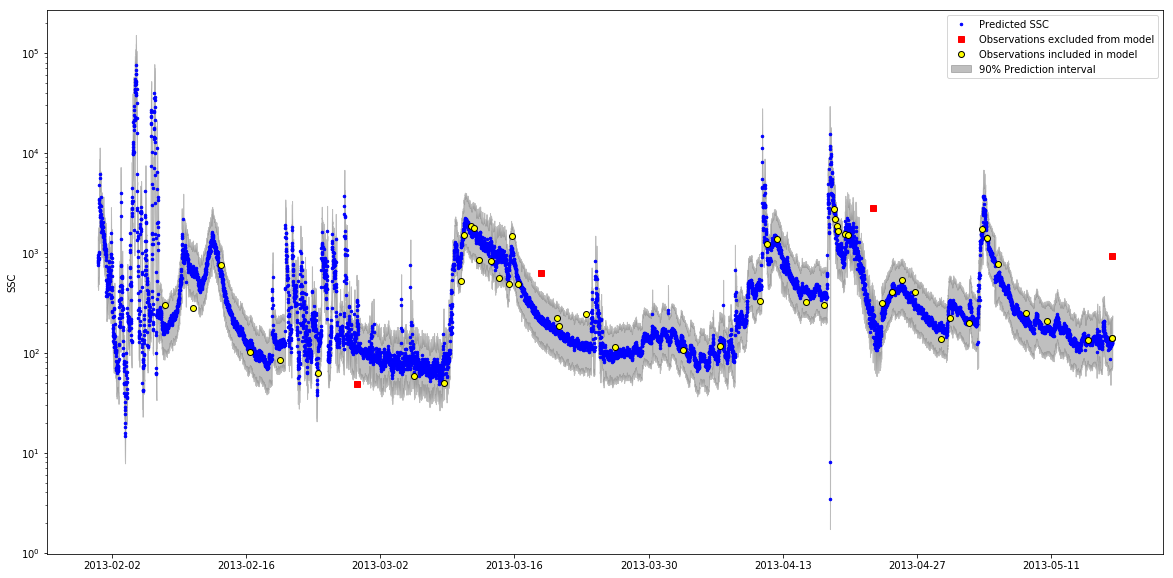

In [16]:
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(111)
rating_model.plot('time series', ax)